# Frist steps for a deep learning model
Created 2025-02-07

### Data preperation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
import time
import re
from matplotlib.axes._axes import Axes as matplotlib_Axis

atom_vector_dict = {x:i for i, x in enumerate(["H", "C", "N", "O", "S"])}
residue_vector_dict = {x:i for i, x in enumerate(["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"])}

rescode_dict = {
    "ALA" : "A",
    "ARG" : "R",
    "ASN" : "N",
    "ASP" : "D",
    "CYS" : "C",
    "GLN" : "Q",
    "GLU" : "E",
    "GLY" : "G",
    "HIS" : "H",
    "ILE" : "I",
    "LEU" : "L",
    "LYS" : "K",
    "MET" : "M",
    "PHE" : "F",
    "PRO" : "P",
    "SER" : "S",
    "THR" : "T",
    "TRP" : "W",
    "TYR" : "Y",
    "VAL" : "V"
}

dist_classes_size = 0.25 # Angström
dist_classes_num = int(5//dist_classes_size) 
dist_classes_max = dist_classes_num*dist_classes_size # Angström
vector_size = dist_classes_num + len(residue_vector_dict)*2 + len(atom_vector_dict)*2
vector_offset_r1 = dist_classes_num
vector_offset_r2 = vector_offset_r1 + len(residue_vector_dict)
vector_offset_a1 = vector_offset_r2 + len(residue_vector_dict) 
vector_offset_a2 = vector_offset_a1 + len(atom_vector_dict)
print(f"Vector size: {vector_size}; Atom 1 offset: {vector_offset_a1}")

Vector size: 70; Atom 1 offset: 60


In [2]:
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()

for p in [solved_DMI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [3]:
libpath = Path("../src").resolve()
print(libpath)
sys.path.insert(0, str(libpath))
import measure_PPI
from measure_PPI import *

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\src


In [4]:
pathObj = {}
for p in AF_DMI_structures_folders:
    measure_PPI.WalkFolder(basePath=p, pathObj=pathObj, files="ranked_0")
DMI_AF_biopy = {}
for (path, structure_name) in pathObj.values():
    biopy_struc, biotite_struc = measure_PPI.OpenStructure(path=path, structure_name=structure_name)
    if biotite_struc is None or biopy_struc is None:
        continue
    DMI_AF_biopy[structure_name] = biopy_struc

[2025-02-14 11:49:55,495 | measure_PPI | INFO] Found 80 structures
[2025-02-14 11:49:55,521 | measure_PPI | INFO] Found 105 structures
[2025-02-14 11:49:55,531 | measure_PPI | INFO] Found 89 structures
[2025-02-14 11:49:55,583 | measure_PPI | INFO] Found 268 structures
[2025-02-14 11:49:59,459 | measure_PPI | WARNING] Can't parse structure LIG_MAD2_1GO4 (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 11:50:00,758 | measure_PPI | WARNING] Can't parse structure LIG_Vh1_VBS_1_1SYQ (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 11:50:00,759 | measure_PPI | WARNING] Can't parse structure LIG_WD40_WDR5_VDV_1_4CY2 (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 11:50:04,071 | measure_PPI | WARNING] Can't parse structure MLIG_LYPXL_L_2_2R02.DLIG_PTAP_UEV_1_1M4P (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 11:50:06,076 | measure_PPI | WARNING] Can't parse structure MLIG_WD40_WDR5_WIN_2_4CY3.D

In [5]:
dataAF = pd.DataFrame(columns=("structure_name",))
for structure_name in DMI_AF_biopy.keys():
    dataAF.loc[len(dataAF)] = {"structure_name": structure_name}
dataAF

,structure_name
0,DEG_APCC_KENBOX_2_4GGD
1,DEG_COP1_1_5IGO
2,DEG_Kelch_Keap1_1_2FLU
3,DEG_Kelch_Keap1_2_3WN7
4,DEG_MDM2_SWIB_1_1YCR
...,...
532,TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...
533,TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGG...
534,TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...
535,TRG_PTS1_2C0L_NAKL.NAGD


In [6]:
regex_paired_DMI = r"^([\w\-]+)_(\w{4})$"
regex_random_DMI = r"^([\w\-]+)_(\w{4})\.([\w\-]+)_(\w{4})$"
regex_mutated_DMI = r"^([\w\-]+)_(\w{4})_(\w+)\.([A-Za-z]+)$"


dataAF["PDB_id"] = None
dataAF["ELM_instance"] = None
dataAF["PDB_id_random_paired"] = None
dataAF["ELM_instance_random_paired"] = None
dataAF["sequence"] = None
dataAF["sequence_mutated"] = None

def structure_name_parsing(row: pd.Series):
    pdb_id, elm_instance, pdb_id_2, elm_instance_2, sequence, sequence_f = None, None, None, None, None, None
    if (r1 := re.search(regex_paired_DMI, row["structure_name"])) is not None and len(r1.groups()) == 2:
        elm_instance = r1.groups()[0]
        pdb_id = r1.groups()[1]
    elif (r := re.search(regex_random_DMI, row["structure_name"])) is not None and len(r.groups()) == 4:
        elm_instance = r.groups()[0]
        pdb_id = r.groups()[1]
        elm_instance_2 = r.groups()[2]
        pdb_id_2 = r.groups()[3]
    elif (r := re.search(regex_mutated_DMI, row["structure_name"])) is not None and len(r.groups()) == 4:
        elm_instance = r.groups()[0]
        pdb_id = r.groups()[1]
        sequence = r.groups()[2]
        sequence_f = r.groups()[3]
    return pd.Series({"structure_name": row["structure_name"], "PDB_id": pdb_id, "ELM_instance": elm_instance, "PDB_id_random_paired": pdb_id_2, "ELM_instance_random_paired": elm_instance_2, "sequence": sequence, "sequence_mutated": sequence_f})

dataAF = dataAF.apply(structure_name_parsing, axis=1)
dataAF

,structure_name,PDB_id,ELM_instance,PDB_id_random_paired,ELM_instance_random_paired,sequence,sequence_mutated
0,DEG_APCC_KENBOX_2_4GGD,4GGD,DEG_APCC_KENBOX_2,None,None,None,None
1,DEG_COP1_1_5IGO,5IGO,DEG_COP1_1,None,None,None,None
2,DEG_Kelch_Keap1_1_2FLU,2FLU,DEG_Kelch_Keap1_1,None,None,None,None
3,DEG_Kelch_Keap1_2_3WN7,3WN7,DEG_Kelch_Keap1_2,None,None,None,None
4,DEG_MDM2_SWIB_1_1YCR,1YCR,DEG_MDM2_SWIB_1,None,None,None,None
...,...,...,...,...,...,...,...
532,TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...,3GB8,TRG_NES_CRM1_1,None,None,EELSQALASSFSVSQD,EELSQALASSDSVSQW
533,TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGG...,1PJM,TRG_NLS_Bipartite_1,None,None,GKRSAEGSNPPKPLKKL,GGGSAEGSNPPKPLKKL
534,TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,1PJM,TRG_NLS_Bipartite_1,None,None,GKRSAEGSNPPKPLKKL,GGRSAEGSNPPKPLKKL
535,TRG_PTS1_2C0L_NAKL.NAGD,2C0L,TRG_PTS1,None,None,NAKL,NAGD


Now the solved structures

In [7]:
pathObj_solved = {}
measure_PPI.WalkFolder(basePath=solved_DMI_structures_path, pathObj=pathObj_solved)
DMI_solved_biopy = {}
for (path, structure_name) in pathObj_solved.values():
    structure_name2 = structure_name.split("_")[0]
    biopy_struc, biotite_struc = measure_PPI.OpenStructure(path=path, structure_name=structure_name2)
    DMI_solved_biopy[structure_name2] = biopy_struc

[2025-02-14 11:50:18,829 | measure_PPI | INFO] Found 138 structures


In [8]:
DMI_solved_biopy.keys()

dict_keys(['1ATP', '1AXC', '1B72', '1B8Q', '1BXX', '1C9I', '1CA9', '1CKA', '1CZY', '1D5G', '1DDV', '1DPU', '1EG4', '1ELR', '1EVH', '1F95', '1FF1', '1GH6', '1GO4', '1GWQ', '1H25', '1JD5', '1JGN', '1JWG', '1KKQ', '1KPS', '1KY7', '1KYU', '1L2Z', '1M4P', '1MFG', '1MKE', '1N4M', '1NTV', '1NW9', '1O0P', '1O6K', '1O9U', '1PD7', '1PJM', '1S70', '1SXJ', '1SYQ', '1UTC', '1YCR', '1YY6', '1ZUB', '2A25', '2A41', '2ASQ', '2B9J', '2BZ8', '2C0L', '2CE8', '2D1K', '2FLU', '2G30', '2GBQ', '2GPH', '2I3S', '2IX7', '2JK9', '2JKR', '2JQ9', '2K42', '2KQS', '2KXH', '2L8J', '2LSI', '2MOW', '2O8G', '2ODD', '2ORZ', '2P1Q', '2PZO', '2R02', '2R03', '2ROC', '2RR3', '2V3S', '2V52', '2V8C', '2W84', '2X04', '2XS0', '2XS1', '2Y48', '2YKT', '2ZNE', '2ZVL', '3AA1', '3BQO', '3EU7', '3GB8', '3GM1', '3HQM', '3MQS', '3N5U', '3OGL', '3QIS', '3RDV', '3SOQ', '3TEI', '3TWU', '3UVK', '3UXG', '3VVW', '3WN7', '3WP0', '3ZFW', '4BH6', '4BXU', '4CQO', '4CY2', '4CY3', '4EOY', '4F0Z', '4FMO', '4GGD', '4H3B', '4H3Q', '4J2X', '4KMD', '4NEE

In [9]:
len(DMI_solved_biopy)

138

In [10]:
dataSolved = pd.DataFrame(columns=("structure_name", "PDB_id"))
for structure_name in DMI_solved_biopy.keys():
    dataSolved.loc[len(dataSolved)] = {"structure_name": None, "PDB_id": structure_name}
_merged = pd.merge(
    left=dataSolved,
    right=dataAF,
    how="left",
    left_on=["PDB_id"],
    right_on=["PDB_id"],
    suffixes=["", "_AF"]
)
_merged["structure_name"] = _merged["structure_name_AF"]
_merged = _merged[np.logical_and(_merged["PDB_id_random_paired"].isna(), _merged["sequence"].isna())]
dataSolved = _merged[["structure_name", "PDB_id"]].copy()
dataSolved

,structure_name,PDB_id
0,DOC_AGCK_PIF_3_1ATP,1ATP
4,LIG_PCNA_PIPBox_1_1AXC,1AXC
8,LIG_HOMEOBOX_1B72,1B72
12,LIG_PDZ_Class_3_1B8Q,1B8Q
17,TRG_ENDOCYTIC_2_1BXX,1BXX
...,...,...
516,LIG_PCNA_APIM_2_5MLW,5MLW
520,DEG_SCF_FBXO31_1_5VZU,5VZU
524,LIG_KLC1_Yacidic_2_6FUZ,6FUZ
528,DOC_CDC14_PxL_1_6G84,6G84


In [11]:
dataAF[np.logical_and(~dataAF["PDB_id_random_paired"].isna(), dataAF["sequence"].isna())]

,structure_name,PDB_id,ELM_instance,PDB_id_random_paired,ELM_instance_random_paired,sequence,sequence_mutated
124,MDEG_APCC_KENBOX_2_4GGD.DTRG_AP2beta_CARGO_1_2G30,4GGD,MDEG_APCC_KENBOX_2,2G30,DTRG_AP2beta_CARGO_1,None,None
125,MDEG_COP1_1_5IGO.DDOC_USP7_MATH_1_3MQS,5IGO,MDEG_COP1_1,3MQS,DDOC_USP7_MATH_1,None,None
126,MDEG_Kelch_Keap1_1_2FLU.DLIG_DLG_GKlike_1_3WP0,2FLU,MDEG_Kelch_Keap1_1,3WP0,DLIG_DLG_GKlike_1,None,None
127,MDEG_Kelch_Keap1_2_3WN7.DDOC_USP7_MATH_2_1YY6,3WN7,MDEG_Kelch_Keap1_2,1YY6,DDOC_USP7_MATH_2,None,None
128,MDEG_MDM2_SWIB_1_1YCR.DLIG_PCNA_APIM_2_5MLW,1YCR,MDEG_MDM2_SWIB_1,5MLW,DLIG_PCNA_APIM_2,None,None
...,...,...,...,...,...,...,...
255,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HePTP_8_2GPH,2RR3,MTRG_ER_FFAT_1,2GPH,DDOC_MAPK_HePTP_8,None,None
256,MTRG_LysEnd_GGAAcLL_1_1JWG.DLIG_SUMO_SIM_anti_...,1JWG,MTRG_LysEnd_GGAAcLL_1,2KQS,DLIG_SUMO_SIM_anti_2,None,None
257,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MyPhoNE_1_1S70,3GB8,MTRG_NES_CRM1_1,1S70,DDOC_PP1_MyPhoNE_1,None,None
258,MTRG_NLS_Bipartite_1_1PJM.DLIG_PDZ_Class_1_1D5G,1PJM,MTRG_NLS_Bipartite_1,1D5G,DLIG_PDZ_Class_1,None,None


* dataSolved: 136
* dataAF paired: 138
* dataAF random: 136
* dataAF mutated: 268 = 134*2

In [12]:
x = DMI_AF_biopy["DEG_APCC_KENBOX_2_4GGD_SKENV.SGENV"]
x

<Structure id=structure>

Creating the metrics

In [13]:
from sklearn.metrics import pairwise_distances
from Bio.PDB.Atom import Atom as BioPy_Atom

class ProteinStructureWarning(Exception):
    def __init__(self, message):            
        super().__init__(message)

def get_distance_matrix(structure_biopy:BioPy_PDBStructure) -> tuple[np.ndarray, list[BioPy_Atom], list[BioPy_Atom]]:
    stopwatch = Stopwatch().Start()
    chains = [c for c in structure_biopy.get_chains()]
    if not len(chains) == 2: raise ProteinStructureWarning(f"The protein needs to have 2 chains but it has {len(chains)}")
    chain1 = structure_biopy[0][chains[0].id]
    chain2 = structure_biopy[0][chains[1].id]
    

    chain1_atoms = np.array([a for a in chain1.get_atoms()])
    chain2_atoms = np.array([a for a in chain2.get_atoms()])
    chain1_coords = [a.coord for a in chain1_atoms]
    chain2_coords = [a.coord for a in chain2_atoms]
    stopwatch.Lap("Parsing the chains and atom arrays")

    distance_matrix = pairwise_distances(chain1_coords,chain2_coords)
    stopwatch.Lap("Distance Matrix")

    return (distance_matrix, chain1_atoms, chain2_atoms)

def get_interface(distance_matrix: np.ndarray, chain1_atoms: list[BioPy_Atom], chain2_atoms: list[BioPy_Atom], cutoff=5.0):
    pair_dist = np.argwhere(distance_matrix <= cutoff) # List of matrix indices where distance is below cutoff
    intf1_atoms = set(chain1_atoms[pair_dist[:, 0]]) # Set of the chain1 atoms with an atom from chain2 closer than cutoff distance
    intf2_atoms = set(chain2_atoms[pair_dist[:, 1]])

    # List of backbone atoms in the interface
    intf1_backbone = [a for a in intf1_atoms if a.name == "CA" and a in intf1_atoms]
    intf2_backbone = [a for a in intf2_atoms if a.name == "CA" and a in intf2_atoms]

    intf1_residues = [a.parent for a in intf1_backbone]
    intf2_residues = [a.parent for a in intf2_backbone]

    # A list for each chain combined to a tuple with the indices of the interface residues. Example : ([23, 445, 470], [26]) 
    backbone_indices_tuple = ([i for i,a in enumerate(chain1_atoms) if a in intf1_backbone], [i for i,a in enumerate(chain2_atoms) if a in intf2_backbone]) 

    # The distance matrix sliced to only the interface backbone atoms. So shape is (len(intf1_backbone), len(intf2_backbone))
    local_dist_matrix = distance_matrix[backbone_indices_tuple[0], :][:, backbone_indices_tuple[1]]

    min_distance = None
    if local_dist_matrix.size != 0:
        min_distance = round(np.min(local_dist_matrix), 3)

    return (intf1_residues, intf2_residues, min_distance)


### Creating the vectors

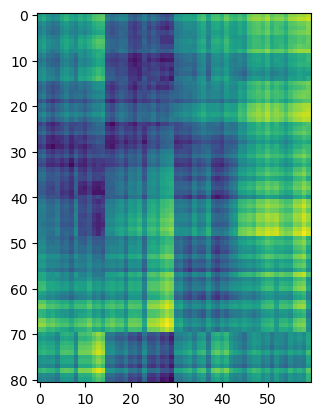

In [ ]:
def interaction_classes_to_vector(dist_class, r1_class, r2_class, a1_class, a2_class):
    vector1 = np.full(shape=(vector_size,), fill_value=0)
    vector1[dist_class] = 1
    vector1[r1_class + vector_offset_r1] = 1
    vector1[r2_class + vector_offset_r2] = 1
    vector1[a1_class + vector_offset_a1] = 1
    vector1[a2_class + vector_offset_a2] = 1
    return vector1

def get_interaction_classes(structure_biopy:BioPy_PDBStructure):
    distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(structure_biopy)
    intf1_residues, intf2_residues, min_distance = get_interface(distance_matrix, chain1_atoms, chain2_atoms)
    if len(intf1_residues) == 0 or len(intf2_residues) == 0:
        return (None, None, None)
    intf1_atoms_indic = np.array([i for i in range(len(chain1_atoms)) if chain1_atoms[i].parent in intf1_residues])
    intf2_atoms_indic = np.array([i for i in range(len(chain2_atoms)) if chain2_atoms[i].parent in intf2_residues])
    intf_dist_matrix = distance_matrix[intf1_atoms_indic, :][:, intf2_atoms_indic]

    chains = [c for c in structure_biopy.get_chains()]
    chain1 = structure_biopy[0][chains[0].id]
    chain1_sequence = np.array([r.res for r in chain1.get_residues()])
    
    intf1_classes = {}
    intf2_classes = {}
    for (a1_i,a2_i), dist in np.ndenumerate(intf_dist_matrix):
        a1 = chain1_atoms[intf1_atoms_indic[a1_i]]
        a2 = chain2_atoms[intf2_atoms_indic[a2_i]]
        r1 = a1.parent
        r2 = a2.parent
        if r1.resname not in residue_vector_dict.keys() or r2.resname not in residue_vector_dict.keys():
            continue
        
        dist_class = max(0, min(int(dist//dist_classes_size), dist_classes_num+1))
        r1_class = residue_vector_dict[r1.resname]
        r2_class = residue_vector_dict[r2.resname]
        a1_class = atom_vector_dict[a1.element]
        a2_class = atom_vector_dict[a2.element]

        classes1 = [dist_class, r1_class, r2_class, a1_class, a2_class]
        classes2 = [dist_class, r2_class, r1_class, a2_class, a1_class]
        
        if dist_class > dist_classes_num:
            continue
        intf1_classes.setdefault(r1, []).append(classes1)
        intf2_classes.setdefault(r2, []).append(classes2)

    return (intf_dist_matrix, intf1_classes, intf2_classes)


intf_dist_matrix, intf1_classes, intf2_classes = get_interaction_classes(DMI_AF_biopy["MDEG_Kelch_Keap1_1_2FLU.DLIG_DLG_GKlike_1_3WP0"])
plt.imshow(intf_dist_matrix)
plt.show()

In [ ]:
dataAF

In [48]:
dataAF[dataAF["structure_name"] == "LIG_NBox_RRM_1_2KXH_FKDALQRARQI.FKDALQRARQD"]

,structure_name,PDB_id,ELM_instance,PDB_id_random_paired,ELM_instance_random_paired,sequence,sequence_mutated
433,LIG_NBox_RRM_1_2KXH_FKDALQRARQI.FKDALQRARQD,2KXH,LIG_NBox_RRM_1,None,None,FKDALQRARQI,FKDALQRARQD


Now creating the vector for each structure

In [29]:
classes_AF = []
for i, (structure_name, biopy_struc) in enumerate(DMI_AF_biopy.items()):
    if i % 25 == 0:
        print(f"Processed {i}/{len(DMI_AF_biopy)}")
    intf_dist_matrix, intf1_classes, intf2_classes = get_interaction_classes(biopy_struc)
    if intf1_classes is not None:
        for res, classes in intf1_classes.items():
            for (dist_class, r1_class, r2_class, a1_class, a2_class) in classes:
                classes_AF.append({"structure_name": structure_name, "chain": "A", "residue": res.id[1], "dist_class": dist_class, "r1_class": r1_class, "r2_class": r2_class, "a1_class": a1_class, "a2_class": a2_class})
    if intf2_classes is not None:
        for res, classes in intf2_classes.items():
            for (dist_class, r1_class, r2_class, a1_class, a2_class) in classes:
                classes_AF.append({"structure_name": structure_name, "chain": "B", "residue": res.id[1], "dist_class": dist_class, "r1_class": r1_class, "r2_class": r2_class, "a1_class": a1_class, "a2_class": a2_class})

classes_AF = pd.DataFrame(classes_AF)
classes_AF

Processed 0/537
Processed 25/537
Processed 50/537
Processed 75/537
Processed 100/537
Processed 125/537
Processed 150/537
Processed 175/537
Processed 200/537
Processed 225/537
Processed 250/537
Processed 275/537
Processed 300/537
Processed 325/537
Processed 350/537
Processed 375/537
Processed 400/537
Processed 425/537
Processed 450/537
Processed 475/537
Processed 500/537
Processed 525/537


,structure_name,chain,residue,dist_class,r1_class,r2_class,a1_class,a2_class
0,DEG_APCC_KENBOX_2_4GGD,A,20,9.711890,3,15,2,2
1,DEG_APCC_KENBOX_2_4GGD,A,20,10.494855,3,15,2,0
2,DEG_APCC_KENBOX_2_4GGD,A,20,8.964781,3,15,2,0
3,DEG_APCC_KENBOX_2_4GGD,A,20,9.523490,3,15,2,0
4,DEG_APCC_KENBOX_2_4GGD,A,20,10.160637,3,15,2,1
...,...,...,...,...,...,...,...,...
20101237,TRG_PTS1_2C0L_NAKL.NAKD,B,4,6.804898,3,2,3,3
20101238,TRG_PTS1_2C0L_NAKL.NAKD,B,4,6.438625,3,2,1,3
20101239,TRG_PTS1_2C0L_NAKL.NAKD,B,4,6.834352,3,2,3,3
20101240,TRG_PTS1_2C0L_NAKL.NAKD,B,4,6.686146,3,2,3,3


In [30]:
all_vectors_AF = pd.merge(
    left=dataAF,
    right=classes_AF,
    how="inner",
    left_on=["structure_name"],
    right_on=["structure_name"],
    suffixes=["", "_classes"],
)
all_vectors_AF

,structure_name,PDB_id,ELM_instance,PDB_id_random_paired,ELM_instance_random_paired,sequence,sequence_mutated,chain,residue,dist_class,r1_class,r2_class,a1_class,a2_class
0,DEG_APCC_KENBOX_2_4GGD,4GGD,DEG_APCC_KENBOX_2,None,None,None,None,A,20,9.711890,3,15,2,2
1,DEG_APCC_KENBOX_2_4GGD,4GGD,DEG_APCC_KENBOX_2,None,None,None,None,A,20,10.494855,3,15,2,0
2,DEG_APCC_KENBOX_2_4GGD,4GGD,DEG_APCC_KENBOX_2,None,None,None,None,A,20,8.964781,3,15,2,0
3,DEG_APCC_KENBOX_2_4GGD,4GGD,DEG_APCC_KENBOX_2,None,None,None,None,A,20,9.523490,3,15,2,0
4,DEG_APCC_KENBOX_2_4GGD,4GGD,DEG_APCC_KENBOX_2,None,None,None,None,A,20,10.160637,3,15,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101237,TRG_PTS1_2C0L_NAKL.NAKD,2C0L,TRG_PTS1,None,None,NAKL,NAKD,B,4,6.804898,3,2,3,3
20101238,TRG_PTS1_2C0L_NAKL.NAKD,2C0L,TRG_PTS1,None,None,NAKL,NAKD,B,4,6.438625,3,2,1,3
20101239,TRG_PTS1_2C0L_NAKL.NAKD,2C0L,TRG_PTS1,None,None,NAKL,NAKD,B,4,6.834352,3,2,3,3
20101240,TRG_PTS1_2C0L_NAKL.NAKD,2C0L,TRG_PTS1,None,None,NAKL,NAKD,B,4,6.686146,3,2,3,3


In [17]:
random_vectors_AF = all_vectors_AF[np.logical_and(~all_vectors_AF["PDB_id_random_paired"].isna(), all_vectors_AF["sequence"].isna())]
random_vectors_AF

,structure_name,PDB_id,ELM_instance,PDB_id_random_paired,ELM_instance_random_paired,sequence,sequence_mutated,chain,residue,dist_class,r1_class,r2_class,a1_class,a2_class
317290,MDEG_APCC_KENBOX_2_4GGD.DTRG_AP2beta_CARGO_1_2G30,4GGD,MDEG_APCC_KENBOX_2,2G30,DTRG_AP2beta_CARGO_1,None,None,A,134,19,1,19,1,0
317291,MDEG_APCC_KENBOX_2_4GGD.DTRG_AP2beta_CARGO_1_2G30,4GGD,MDEG_APCC_KENBOX_2,2G30,DTRG_AP2beta_CARGO_1,None,None,A,134,20,1,19,1,0
317292,MDEG_APCC_KENBOX_2_4GGD.DTRG_AP2beta_CARGO_1_2G30,4GGD,MDEG_APCC_KENBOX_2,2G30,DTRG_AP2beta_CARGO_1,None,None,A,134,19,1,19,0,1
317293,MDEG_APCC_KENBOX_2_4GGD.DTRG_AP2beta_CARGO_1_2G30,4GGD,MDEG_APCC_KENBOX_2,2G30,DTRG_AP2beta_CARGO_1,None,None,A,134,17,1,19,0,0
317294,MDEG_APCC_KENBOX_2_4GGD.DTRG_AP2beta_CARGO_1_2G30,4GGD,MDEG_APCC_KENBOX_2,2G30,DTRG_AP2beta_CARGO_1,None,None,A,134,17,1,19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577881,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,2C0L,MTRG_PTS1,4CY3,DLIG_WD40_WDR5_WIN_2,None,None,B,2,17,0,18,0,1
577882,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,2C0L,MTRG_PTS1,4CY3,DLIG_WD40_WDR5_WIN_2,None,None,B,2,19,0,18,1,0
577883,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,2C0L,MTRG_PTS1,4CY3,DLIG_WD40_WDR5_WIN_2,None,None,B,2,15,0,18,0,0
577884,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,2C0L,MTRG_PTS1,4CY3,DLIG_WD40_WDR5_WIN_2,None,None,B,2,20,0,18,0,1


In [18]:
outDir = Path("./resources").resolve()
print(outDir)
random_vectors_AF.to_csv(outDir / "vectors_randomizedDMI.csv", index=False)

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\dev\resources


Now also for the solved structures

In [19]:
classes_Solved = []
for i, (structure_name, biopy_struc) in enumerate(DMI_solved_biopy.items()):
    if i % 25 == 0:
        print(f"Processed {i}/{len(DMI_solved_biopy)}")
    intf_dist_matrix, intf1_classes, intf2_classes = get_interaction_classes(biopy_struc)
    if intf1_classes is not None:
        for res, classes in intf1_classes.items():
            for (dist_class, r1_class, r2_class, a1_class, a2_class) in classes:
                classes_Solved.append({"PDB_id": structure_name, "chain": "A", "residue": res.id[1], "dist_class": dist_class, "r1_class": r1_class, "r2_class": r2_class, "a1_class": a1_class, "a2_class": a2_class})
    if intf2_classes is not None:
        for res, classes in intf2_classes.items():
            for (dist_class, r1_class, r2_class, a1_class, a2_class) in classes:
                classes_Solved.append({"PDB_id": structure_name, "chain": "B", "residue": res.id[1], "dist_class": dist_class, "r1_class": r1_class, "r2_class": r2_class, "a1_class": a1_class, "a2_class": a2_class})

classes_Solved = pd.DataFrame(classes_Solved)
classes_Solved

Processed 0/138
Processed 25/138
Processed 50/138
Processed 75/138
Processed 100/138
Processed 125/138


,PDB_id,chain,residue,dist_class,r1_class,r2_class,a1_class,a2_class
0,1ATP,A,76,20,11,13,1,1
1,1ATP,A,76,17,11,13,1,1
2,1ATP,A,76,19,11,13,1,1
3,1ATP,A,76,20,11,13,1,0
4,1ATP,A,76,15,11,13,1,0
...,...,...,...,...,...,...,...,...
382945,7DS2,B,323,19,13,6,0,0
382946,7DS2,B,323,19,13,6,0,0
382947,7DS2,B,323,19,13,6,1,0
382948,7DS2,B,323,16,13,6,0,0


In [20]:
classes_Solved

,PDB_id,chain,residue,dist_class,r1_class,r2_class,a1_class,a2_class
0,1ATP,A,76,20,11,13,1,1
1,1ATP,A,76,17,11,13,1,1
2,1ATP,A,76,19,11,13,1,1
3,1ATP,A,76,20,11,13,1,0
4,1ATP,A,76,15,11,13,1,0
...,...,...,...,...,...,...,...,...
382945,7DS2,B,323,19,13,6,0,0
382946,7DS2,B,323,19,13,6,0,0
382947,7DS2,B,323,19,13,6,1,0
382948,7DS2,B,323,16,13,6,0,0


In [21]:
outDir = Path("./resources").resolve()
print(outDir)
classes_Solved.to_csv(outDir / "vectors_solved.csv", index=False)

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\dev\resources


## New vector architecture

In [23]:
def aa_properties(resname: str):
    alpihatic = resname in ["ALA", "GLY", "ISO", "LEU", "PRO", "VAL"]
    aromatic = resname in ["PHE", "TRP", "TYR"]
    acidic = resname in ["ASP", "GLU"]
    basic = resname in ["ARG", "HIS", "LYS"]
    sulphuric = resname in ["CYS", "MET"]
    amidic = resname in ["ASN", "GLN"]
    return [alpihatic, aromatic, acidic, basic, sulphuric, amidic]


In [1]:
def get_interaction_classes_mutated(structure_biopy:BioPy_PDBStructure):
    distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(structure_biopy)
    intf1_residues, intf2_residues, min_distance = get_interface(distance_matrix, chain1_atoms, chain2_atoms, cutoff=5.0)
    if len(intf1_residues) == 0 or len(intf2_residues) == 0:
        return (None, None, None)
    intf1_atoms_indic = np.array([i for i in range(len(chain1_atoms)) if chain1_atoms[i].parent in intf1_residues])
    intf2_atoms_indic = np.array([i for i in range(len(chain2_atoms)) if chain2_atoms[i].parent in intf2_residues])
    intf_dist_matrix = distance_matrix[intf1_atoms_indic, :][:, intf2_atoms_indic]
    
    intf1_classes = {}
    intf2_classes = {}
    for (a1_i,a2_i), dist in np.ndenumerate(intf_dist_matrix):
        a1 = chain1_atoms[intf1_atoms_indic[a1_i]]
        a2 = chain2_atoms[intf2_atoms_indic[a2_i]]
        r1 = a1.parent
        r2 = a2.parent
        if r1.resname not in residue_vector_dict.keys() or r2.resname not in residue_vector_dict.keys():
            continue
        
        # Amino accid 1 properties
        r1_class = residue_vector_dict[r1.resname]
        r2_class = residue_vector_dict[r2.resname]
        a1_class = atom_vector_dict[a1.element]
        a2_class = atom_vector_dict[a2.element]

        classes1 = [dist, r1_class, r2_class, a1_class, a2_class]
        classes2 = [dist, r2_class, r1_class, a2_class, a1_class]
        
        intf1_classes.setdefault(r1, []).append(classes1)
        intf2_classes.setdefault(r2, []).append(classes2)

    return (intf_dist_matrix, intf1_classes, intf2_classes, chain1_sequence)


intf_dist_matrix, intf1_classes, intf2_classes, chain1_sequence = get_interaction_classes(DMI_AF_biopy["LIG_NBox_RRM_1_2KXH_FKDALQRARQI.FKDALQRARQD"])
plt.imshow(intf_dist_matrix)
plt.show()

NameError: name 'BioPy_PDBStructure' is not defined

In [ ]:
classes_AF = []

dataAF_mutated = dataAF[~dataAF["sequence_mutated"].isna()].copy()

for i, row in dataAF_mutated.iterrows():
    if i % 25 == 0:
        print(f"Processed {i}/{len(DMI_AF_biopy)}")
    structure_name = row["structure_name"]
    print(row)
    biopy_struc = DMI_AF_biopy[structure_name]
    intf_dist_matrix, intf1_classes, intf2_classes, chain1_sequence = get_interaction_classes(biopy_struc)
    for n in range(len(str(row["sequence"]))):
        ri, rf = str(row["sequence"])[n], str(row["sequence_mutated"])[n]
        if ri != rf:
    print(chain1_sequence)
    print(re.search(str(row["sequence_mutated"]), chain1_sequence))
    break

"""
for i, (structure_name, biopy_struc) in enumerate(DMI_AF_biopy.items()):
    if i % 25 == 0:
        print(f"Processed {i}/{len(DMI_AF_biopy)}")
    intf_dist_matrix, intf1_classes, intf2_classes = get_interaction_classes(biopy_struc)
    if intf1_classes is not None:
        for res, classes in intf1_classes.items():
            for (dist_class, r1_class, r2_class, a1_class, a2_class) in classes:
                classes_AF.append({"structure_name": structure_name, "chain": "A", "residue": res.id[1], "dist_class": dist_class, "r1_class": r1_class, "r2_class": r2_class, "a1_class": a1_class, "a2_class": a2_class})
    if intf2_classes is not None:
        for res, classes in intf2_classes.items():
            for (dist_class, r1_class, r2_class, a1_class, a2_class) in classes:
                classes_AF.append({"structure_name": structure_name, "chain": "B", "residue": res.id[1], "dist_class": dist_class, "r1_class": r1_class, "r2_class": r2_class, "a1_class": a1_class, "a2_class": a2_class})
"""
classes_AF = pd.DataFrame(classes_AF)
classes_AF

structure_name                DEG_APCC_KENBOX_2_4GGD_SKENV.SGENV
PDB_id                                                      4GGD
ELM_instance                                   DEG_APCC_KENBOX_2
PDB_id_random_paired                                        None
ELM_instance_random_paired                                  None
sequence                                                   SKENV
sequence_mutated                                           SGENV
Name: 269, dtype: object
[<Residue SER het=  resseq=1 icode= >, <Residue GLY het=  resseq=2 icode= >, <Residue GLU het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >, <Residue VAL het=  resseq=5 icode= >]
SGENV
<re.Match object; span=(0, 5), match='SGENV'>


""


## Test Code

In [25]:
print(chain1_atoms.shape, chain2_atoms.shape)
intf1_atoms_indic = np.array([i for i in range(len(chain1_atoms)) if chain1_atoms[i].parent in intf1_residues])
intf2_atoms_indic = np.array([i for i in range(len(chain2_atoms)) if chain2_atoms[i].parent in intf2_residues])
print(intf1_atoms_indic.shape, intf2_atoms_indic.shape)
intf_dist_matrix = distance_matrix[intf1_atoms_indic, :][:, intf2_atoms_indic]
intf_dist_matrix.shape

NameError: name 'chain1_atoms' is not defined

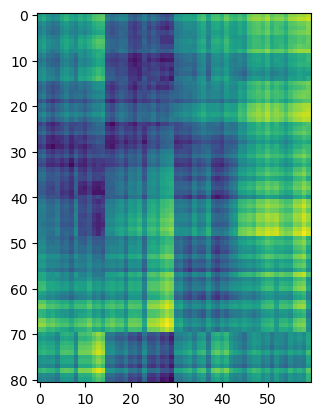

In [79]:
plt.imshow(intf_dist_matrix)
plt.show()

In [161]:
i = 0 
intf1_vectors = {}
intf2_vectors = {}
for (a1_i,a2_i), dist in np.ndenumerate(img):
    a1 = chain1_atoms[intf1_atoms_indic[a1_i]]
    a2 = chain2_atoms[intf2_atoms_indic[a2_i]]
    r1 = a1.parent
    r2 = a2.parent
    
    dist_class = max(0, min(int(dist//dist_classes_size), dist_classes_num+1))
    r1_class = residue_vector_dict[r1.resname]
    r2_class = residue_vector_dict[r2.resname]
    a1_class = atom_vector_dict[a1.element]
    a2_class = atom_vector_dict[a2.element]
    
    if dist_class > dist_classes_num:
        continue
    

    vector1 = np.full(shape=(vector_size,), fill_value=0)
    vector1[dist_class] = 1
    vector1[r1_class + vector_offset_r1] = 1
    vector1[r2_class + vector_offset_r2] = 1
    vector1[a1_class + vector_offset_a1] = 1
    vector1[a2_class + vector_offset_a2] = 1

    intf1_vectors.setdefault(r1, []).append(vector1)
    vector2 = np.full(shape=(vector_size,), fill_value=0)
    vector2[dist_class] = 1
    vector2[r1_class + vector_offset_r1] = 1
    vector2[r2_class + vector_offset_r2] = 1
    vector2[a1_class + vector_offset_a1] = 1
    vector2[a2_class + vector_offset_a2] = 1
    intf2_vectors.setdefault(r2, []).append(vector2)

print(len(intf1_vectors), len(intf2_vectors))

5 3
